In [ ]:
# import numpy as np
# import pandas as pd
# import glob

# all_item_metadata = []
# categories = ['Movies_and_TV', 'Clothing_Shoes_and_Jewelry', 'All_Beauty', 'Digital_Music', 'Grocery_and_Gourmet_Food', 'Sports_and_Outdoors', 'Health_and_Personal_Care', 'Books', 'Electronics', 'CDs_and_Vinyl', 'Video_Games', 'Automotive']

# for category in categories:
#     item_metadata = pd.read_csv(f'Amazon Raw Data/{category}_item_metadata_raw.csv')
#     item_metadata['dataset_category'] = category
#     all_item_metadata.append(item_metadata)

# # ✅ Combine all metadata into a single DataFrame
# combined_item_metadata = pd.concat(all_item_metadata, ignore_index=True)
# print(f"Total products combined: {combined_item_metadata.shape[0]}")
# combined_item_metadata.to_csv("Amazon Processed Dataset/combined_item_metadata_original_features.csv", index=False)

Limitations:

1. Since we're using sampling for loading larger categories for faster computation, we risk losing out on good quality products that might make better recommendations.
2. Consider categorical filtering within each category. Like, self improvement books are marketable, while textbooks might not be. Context switching based on category of influencer.

Amazon:Influencer

average_rating : comprehensive_score<br>
rating_number : predicted_likes/avg_likes_per_post(k)<br>
no_of_reviews : predicted_likes<br>
rating_trend_slope : engagement_change<br>
time_weighted_sentiment : influencer_product_fit<br>
product context TF-IDF(title + features + description) : product + ad_product_category + advertising_brand + category<br>

### Ideas

1. Consider brand level performance metrics on social media as it's relevant in product reception, in turn affecting revenue.
2. Add a booster score for certain products based on age to make sure they are recommended? Consider user profiles in boosting score and generate new recommendations?
3. Consider categorical filtering within each category. Like, self improvement books are marketable, while textbooks might not be. Context switching based on category of influencer.
4. Topic modeling to understand the relationship between an influencer and their audience.
5. Improve the scores, make them more intuitive.

# Autoencoder Approach

In [ ]:
# import google.colab as colab
# import os
# colab.drive.mount('/content/drive/')
# os.chdir('/content/drive/MyDrive/Master of Analytics/INDENG 243 - Analytics Lab/Sponsorship Recommendation System/Online Influencer Product Recommendation System')
# colab.drive.mount('/content/drive/MyDrive/Master of Analytics/INDENG 243 - Analytics Lab/Sponsorship Recommendation System/Online Influencer Product Recommendation System')
# colab.drive.mount('/content/drive/MyDrive/MasterofAnalytics/INDENG243-AnalyticsLab/SponsorshipRecommendationSystem/OnlineInfluencerProductRecommendationSystem')
# colab.drive.mount("/content/drive/MyDrive/'Master of Analytics'/'INDENG 243 - Analytics Lab'/'Sponsorship Recommendation System'/'Online Influencer Product Recommendation System'")
# colab.drive.mount('/content/drive/MyDrive/Master of Analytics/INDENG 243 - Analytics Lab/Sponsorship Recommendation System/Online Influencer Product Recommendation System')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import glob

# ✅ Initialize storage for all categories
all_feature_vectors = []
all_item_metadata = []

# ✅ List of categories
# categories = ['All_Beauty', 'Health_and_Personal_Care', 'Baby_Products', 'Grocery_and_Gourmet_Food', 'Sports_and_Outdoors', 'Pet_Supplies', 'Software', 'Electronics', 'Tools_and_Home_Improvement']


# As per sponsored product category distribution
categories = ['Movies_and_TV', 'Clothing_Shoes_and_Jewelry', 'All_Beauty', 'Digital_Music', 'Grocery_and_Gourmet_Food', 'Sports_and_Outdoors', 'Health_and_Personal_Care', 'Books', 'Electronics', 'CDs_and_Vinyl', 'Video_Games', 'Automotive']

# ✅ Load and merge feature vectors for each category
for category in categories:
    # Load feature vector (.npy)
    feature_vector = np.load(f'Amazon Processed Dataset/{category}_feature_vector.npy')

    # Load item metadata (.csv)
    item_metadata = pd.read_csv(f'Amazon Processed Dataset/{category}_item_metadata_w_features.csv')
    item_metadata['dataset_category'] = category

    # Ensure the number of rows in metadata matches the number of feature vectors
    assert feature_vector.shape[0] == item_metadata.shape[0], f"Mismatch in {category}: {feature_vector.shape[0]} vectors vs {item_metadata.shape[0]} products"

    # ✅ Store data for later merging
    all_feature_vectors.append(feature_vector)
    all_item_metadata.append(item_metadata)

# ✅ Stack all feature vectors into a single matrix
combined_amazon_feature_vectors = np.vstack(all_feature_vectors)

# ✅ Combine all metadata into a single DataFrame
combined_item_metadata = pd.concat(all_item_metadata, ignore_index=True)

# ✅ Final Check
print(f"Total products combined: {combined_item_metadata.shape[0]}")
print(f"Feature vector shape: {combined_amazon_feature_vectors.shape}")

# ✅ Save the final dataset
np.save("Amazon Processed Dataset/combined_amazon_feature_vectors.npy", combined_amazon_feature_vectors)
combined_item_metadata.to_csv("Amazon Processed Dataset/combined_item_metadata.csv", index=False)

Total products combined: 176528
Feature vector shape: (176528, 773)


In [ ]:
import numpy as np
import pandas as pd
combined_item_metadata = pd.read_csv(f'Amazon Processed Dataset/combined_item_metadata.csv')
combined_amazon_feature_vectors = np.load(f'Amazon Processed Dataset/combined_amazon_feature_vectors.npy')

C:\Users\anira\AppData\Local\Temp\ipykernel_23000\3682974874.py:3: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_item_metadata = pd.read_csv(f'Amazon Processed Dataset/combined_item_metadata.csv')


In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
# Utility functions and variables

def merge_features(df): # tfidf_matrix
    num_cols = df.select_dtypes(include=['number']).columns
    numerical_features = df[num_cols].to_numpy()
    product_sbert_embedding = np.array(df['product_sbert_embedding'].tolist())

    final_features = np.hstack((numerical_features, product_sbert_embedding))

    return final_features

import re, emoji, inflect
import nltk
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import stopwords, words

slang_dict = {
    "gonna": "going to", "wanna": "want to", "idk": "i do not know",
    "b4": "before", "gr8": "great", "luv": "love", "thx": "thanks"
}

shortened_dict = {
    "lite": "light", "nite": "night", "coz": "because",
    "fav": "favorite", "biz": "business", "tmrw": "tomorrow", "u": "you"
}

# stop_words = set(stopwords.words('english'))
# negations = {"not", "no", "never", "none", "nor", "n't"}  # Keep important negations
# filtered_stopwords = stop_words - negations
word_list = set(words.words()) # Load English word dictionary

def reduce_elongation(text):
    def replace_match(match):
        word = match.group(0)
        # Only reduce if it's not a real English word
        if word.lower() not in word_list:
            return re.sub(r'(.)\1{2,}', r'\1\1', word)  # Keep max 2 repetitions
        return word

    return re.sub(r'\b(\w+?)\1+\b', replace_match, text)

def replace_number(match):
    p = inflect.engine()
    num = match.group()
    try:
        # Ensure input is a valid number
        if isinstance(num, (int, float)):
            num = int(num)  # Convert float to int to avoid issues
            return p.number_to_words(num)
        return ''  # Skip invalid values
    except:
        return ''  # Skip errors

def clean_text(text):
    text = str(text).lower()  # Lowercase
    text = emoji.demojize(text)  # Convert emojis
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^a-z0-9\s]', ' ', text)  # Remove special characters
    text = " ".join([slang_dict.get(word, word) for word in text.split()])  # Replace slang
    text = " ".join([shortened_dict.get(word, word) for word in text.split()])  # Replace shortened words
    text = reduce_elongation(text)  # Remove letter elongations
    text = re.sub(r'\b\d+\b', replace_number, text)  # Replace numbers with text
    # text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

from sklearn.preprocessing import MinMaxScaler

def min_max_scale_dataframe(df, columns = []):
    columns = df.select_dtypes(include=['number']).columns
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])

    return df, scaler

import torch

from sentence_transformers import SentenceTransformer
# Load SBERT model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("all-MiniLM-L6-v2").to(device)  # Fast & good for semantic similarity
    
# Function to encode aggregated reviews
def encode_reviews(text):
    return model.encode(text, convert_to_numpy=True)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\anira\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
candidate_products = pd.read_csv('product_list_with_comprehensive_score.csv')
candidate_products.head()

,Unnamed: 0,user_id,user_name,follower_count,category,avg_likes_per_post(k),ad_product_name,ad_product_category,advertising_brand,predicted_likes(k),engagement_change,recommendation_score,product_info,influencer_product_fit,comprehensive_score
0,0,171146,shanedawson,7300391,Video creator,1053.3,movie,Movies_and_TV,na,1465.2,0.391,0.149344,movies_and_tv movie na,0.291487,69.9
1,30,171146,shanedawson,7300391,Video creator,1053.3,movie,Movies_and_TV,20th century studios,1448.4,0.375,0.019987,movies_and_tv movie 20th century studios,0.348682,68.3
2,38,171146,shanedawson,7300391,Video creator,1053.3,movie,Movies_and_TV,disney,1448.4,0.375,0.017440,movies_and_tv movie disney,0.337474,67.9
3,24,171146,shanedawson,7300391,Video creator,1053.3,talk_show,Movies_and_TV,the_tonight_show,1295.0,0.229,0.021959,movies_and_tv talk_show the_tonight_show,0.375464,64.2
4,31,171146,shanedawson,7300391,Video creator,1053.3,tv_show_premieres,Movies_and_TV,na,1315.6,0.249,0.019980,movies_and_tv tv_show_premieres na,0.308844,62.5


In [ ]:
candidate_products.shape

(16104, 15)

In [ ]:
candidate_products.drop(candidate_products[candidate_products['ad_product_name'] == 'na'].index, axis = 0, inplace = True)
candidate_products['product_context'] = candidate_products['ad_product_name'] + ' ' + candidate_products['ad_product_category'] + ' ' + candidate_products['advertising_brand'] + ' ' + candidate_products['category'] + ' ' + candidate_products['product_info']
candidate_products['cleaned_context'] = candidate_products['product_context'].apply(clean_text)
candidate_products.drop(candidate_products[candidate_products['cleaned_context'].isna()].index, axis = 0, inplace = True)
num_cols = ['follower_count', 'avg_likes_per_post(k)', 'predicted_likes(k)', 'engagement_change', 'recommendation_score', 'influencer_product_fit', 'comprehensive_score']
for col in num_cols:
    candidate_products[col] = candidate_products[col].astype(float).fillna(0)
candidate_products, scaler = min_max_scale_dataframe(candidate_products, columns=num_cols)

candidate_products['product_sbert_embedding'] = candidate_products['cleaned_context'].apply(encode_reviews)

candidate_feature_vector = merge_features(candidate_products)

In [ ]:
combined_amazon_feature_vectors.shape

(176528, 773)

In [ ]:
candidate_feature_vector.shape

(14963, 393)

In [ ]:
from sklearn.decomposition import PCA

# Reduce Pool 2 embeddings from 773 to 746 dimensions
pca = PCA(n_components=746)
amazon_pca_features = pca.fit_transform(combined_amazon_feature_vectors)

# Check explained variance
print(f"Total variance retained: {sum(pca.explained_variance_ratio_):.4f}")  # Should be ~95-99%

Total variance retained: 0.9994


What Defines an Optimal Latent Dimension?
The best latent_dim should: ✅ Compress data efficiently while preserving key features.
✅ Minimize reconstruction loss (MSE) in the autoencoder.
✅ Maximize FAISS retrieval performance (high cosine similarity).

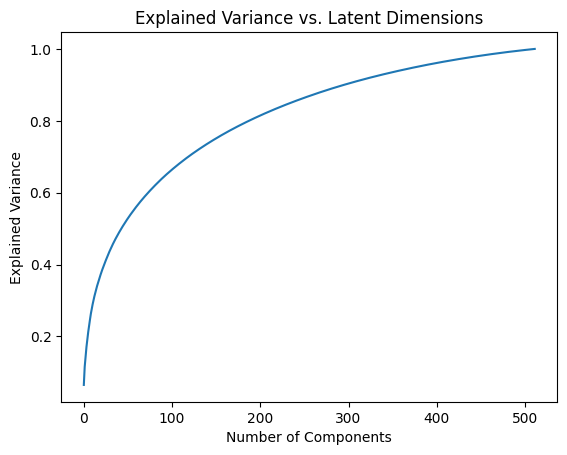

In [ ]:
# from sklearn.decomposition import PCA
# import numpy as np
# import matplotlib.pyplot as plt

# latent_dim_range = 512

# # Fit PCA to Pool 2 embeddings
# pca = PCA(n_components=latent_dim_range)  # Test a range of dims
# pca.fit(amazon_pca_features)

# # Plot cumulative variance
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Explained Variance')
# plt.title('Explained Variance vs. Latent Dimensions')
# plt.show()

Since the curve almost flattens out after ~500, the latent space can be mapped to a dimension close to 500, without losing much information for Amazon Dataset features.

Since we have 93k Amazon products and 16k Influencer sponsored products, we need an autoencoder that can effectively map them into a shared latent space, despite the difference in dataset sizes.

We will use batch-balanced training to ensure equal number of samples are used at each training step. This will also reduce the computational load, as opposed to oversampling.

In [ ]:
amazon_pca_features.shape

(176528, 746)

✅ Balanced training: Uses multiple subsets of Pool 2 to prevent bias.<br>
✅ Prevents overfitting: Uses dropout, batch normalization, and multiple rounds.<br>
✅ Optimized latent space (latent_dim = 256): FAISS-compatible but avoids overfitting.<br>
✅ Training visualization: Clearly shows overfitting if validation loss diverges.<br>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import faiss
import random
import matplotlib.pyplot as plt

# Latent space size
latent_dim = 256  # Optimized for FAISS compatibility

# === Pool 1 Encoder (Influencer Products) ===
class EncoderPool1(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(EncoderPool1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, latent_dim)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

# === Pool 2 Encoder (Amazon Products) ===
class EncoderPool2(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(EncoderPool2, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, latent_dim)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

# === Pool 2 Decoder ===
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, output_dim)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.tanh(self.fc2(x))  # Match Pool 2's original feature space
        return x

# === Autoencoder ===
class Autoencoder(nn.Module):
    def __init__(self, encoder_p2, decoder):
        super(Autoencoder, self).__init__()
        self.encoder_p2 = encoder_p2  # Only Pool 2 encoder is inside autoencoder
        self.decoder = decoder
    
    def encode(self, x):
        return self.encoder_p2(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

from sklearn.model_selection import train_test_split
# Sample function for balanced category sampling
def sample_pool2_uniformly(pool1_data, pool2_data, pool2_categories, num_samples=16000, test_size=0.1):
    df = pd.DataFrame({'category': pool2_categories})
    sampled_indices = []
    unique_categories = df['category'].unique()
    num_categories = len(unique_categories)
    samples_per_category = num_samples // num_categories
    
    for category in unique_categories:
        category_indices = df[df['category'] == category].index
        sampled = np.random.choice(category_indices, min(samples_per_category, len(category_indices)), replace=False)
        sampled_indices.extend(sampled)
    
    if len(sampled_indices) < num_samples:
        extra_samples = np.random.choice(df.index, num_samples - len(sampled_indices), replace=False)
        sampled_indices.extend(extra_samples)
    
    train_data_p1, val_data_p1 = train_test_split(pool1_data, test_size=test_size, random_state=42)
    train_data_p2, val_data_p2 = train_test_split(pool2_data[sampled_indices], test_size=test_size, random_state=42)
    return train_data_p1, val_data_p1, train_data_p2, val_data_p2
    
from torch.utils.data import DataLoader, TensorDataset
# Training function
def train_autoencoder(autoencoder, train_data_p1, train_data_p2, val_data_p1, val_data_p2, epochs=10, learning_rate=0.0001, patience=10, batch_size = 32):
    train_tensor_p1 = torch.tensor(train_data_p1, dtype=torch.float32)
    train_tensor_p2 = torch.tensor(train_data_p2, dtype=torch.float32)
    val_tensor_p1 = torch.tensor(val_data_p1, dtype=torch.float32)
    val_tensor_p2 = torch.tensor(val_data_p2, dtype=torch.float32)
    
    # Create DataLoaders
    train_loader_p1 = DataLoader(TensorDataset(train_tensor_p1), batch_size=batch_size, shuffle=True)
    train_loader_p2 = DataLoader(TensorDataset(train_tensor_p2), batch_size=batch_size, shuffle=True)
    val_loader_p1 = DataLoader(TensorDataset(val_tensor_p1), batch_size=batch_size, shuffle=False)
    val_loader_p2 = DataLoader(TensorDataset(val_tensor_p2), batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder.to(device)
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.MSELoss()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        autoencoder.train()

        epoch_loss = 0
        
        for batch_p1, batch_p2 in zip(train_loader_p1, train_loader_p2):
            optimizer.zero_grad()
            inputs_p1 = batch_p1[0].to(device)
            inputs_p2 = batch_p2[0].to(device)
            
            encoded_p1 = encoder_pool1(inputs_p1)
            encoded_p2 = autoencoder.encode(inputs_p2)
            reconstructed_p2 = autoencoder.decode(encoded_p2)
            
            loss_p1 = criterion(encoded_p1, encoded_p2)
            loss_p2 = criterion(reconstructed_p2, inputs_p2)
            loss = loss_p1 + loss_p2  # Joint loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader_p1))
        
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_p1, batch_p2 in zip(val_loader_p1, val_loader_p2):
                val_inputs_p1 = batch_p1[0].to(device)
                val_inputs_p2 = batch_p2[0].to(device)

                val_encoded_p1 = encoder_pool1(val_inputs_p1)
                val_encoded_p2 = autoencoder.encode(val_inputs_p2)
                val_reconstructed_p2 = autoencoder.decoder(val_encoded_p2)
                
                val_loss_p1 = criterion(val_encoded_p1, val_encoded_p2)
                val_loss_p2 = criterion(val_reconstructed_p2, val_inputs_p2)
                val_loss += val_loss_p1.item() + val_loss_p2.item()
        val_losses.append(val_loss / len(val_loader_p1))
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader_p1):.4f}, Val Loss: {val_loss / len(val_loader_p1):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    
    return train_losses, val_losses

# Function to save the model
def save_model(model, path="autoencoder.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Function to load the model
def load_model(model, path="autoencoder.pth"):
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Model loaded from {path}")

# Instantiate model
encoder_pool1 = EncoderPool1(input_dim=candidate_feature_vector.shape[1], latent_dim=latent_dim)
encoder_pool2 = EncoderPool2(input_dim=amazon_pca_features.shape[1], latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, output_dim=amazon_pca_features.shape[1])
autoencoder = Autoencoder(encoder_pool2, decoder)

In [ ]:
def train_autoencoder_multiple_rounds(autoencoder, pool1_data, pool2_data, pool2_categories,
                                      epochs_per_round=10, num_rounds=5, batch_size=32):
    train_losses = []
    val_losses = []

    for round_num in range(num_rounds):
        print(f"\n🔄 Training Round {round_num+1}/{num_rounds}")
        
        sampled_train_pool1, sampled_val_pool1, sampled_train_pool2, sampled_val_pool2 = sample_pool2_uniformly(pool1_data, pool2_data, pool2_categories, num_samples=candidate_feature_vector.shape[0], test_size=0.1)

        train_loss, val_loss = train_autoencoder(autoencoder, sampled_train_pool1, sampled_train_pool2, sampled_val_pool1, sampled_val_pool2, epochs=epochs_per_round, batch_size=batch_size, learning_rate = 0.0001, patience=5)

        train_losses.extend(train_loss)
        val_losses.extend(val_loss)


    return train_losses, val_losses



🔄 Training Round 1/5
Epoch 1/50, Loss: 0.0250, Val Loss: 0.0219
Epoch 2/50, Loss: 0.0215, Val Loss: 0.0212
Epoch 3/50, Loss: 0.0209, Val Loss: 0.0209
Epoch 4/50, Loss: 0.0207, Val Loss: 0.0209
Epoch 5/50, Loss: 0.0206, Val Loss: 0.0208
Epoch 6/50, Loss: 0.0205, Val Loss: 0.0209
Epoch 7/50, Loss: 0.0204, Val Loss: 0.0206
Epoch 8/50, Loss: 0.0204, Val Loss: 0.0207
Epoch 9/50, Loss: 0.0204, Val Loss: 0.0207
Epoch 10/50, Loss: 0.0204, Val Loss: 0.0205
Epoch 11/50, Loss: 0.0204, Val Loss: 0.0205
Epoch 12/50, Loss: 0.0203, Val Loss: 0.0206
Epoch 13/50, Loss: 0.0203, Val Loss: 0.0206
Epoch 14/50, Loss: 0.0204, Val Loss: 0.0205
Epoch 15/50, Loss: 0.0203, Val Loss: 0.0204
Epoch 16/50, Loss: 0.0204, Val Loss: 0.0203
Epoch 17/50, Loss: 0.0203, Val Loss: 0.0202
Epoch 18/50, Loss: 0.0203, Val Loss: 0.0205
Epoch 19/50, Loss: 0.0203, Val Loss: 0.0204
Epoch 20/50, Loss: 0.0203, Val Loss: 0.0203
Epoch 21/50, Loss: 0.0203, Val Loss: 0.0202
Epoch 22/50, Loss: 0.0203, Val Loss: 0.0202
Epoch 23/50, Loss: 

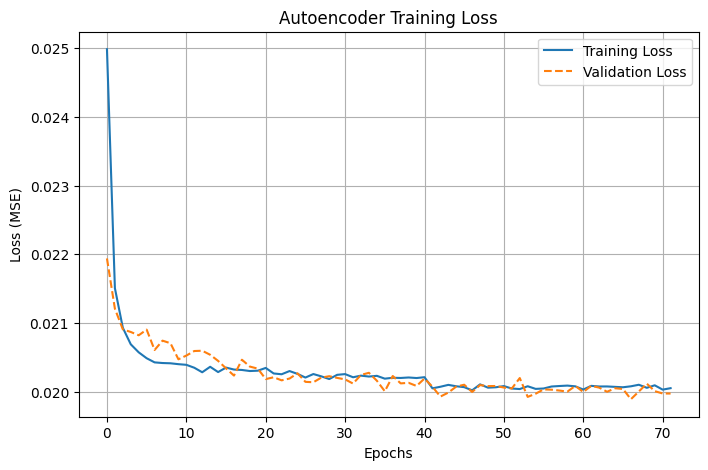

In [ ]:
# Train Autoencoder in Multiple Rounds
train_losses, val_losses = train_autoencoder_multiple_rounds(autoencoder, candidate_feature_vector, pool2_data = amazon_pca_features, pool2_categories = combined_item_metadata['dataset_category'], num_rounds=5, epochs_per_round = 50, batch_size = 64)

# Save the trained model
save_model(autoencoder)

# # Load the trained model
# load_model(autoencoder)


# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.grid()
plt.show()

In [196]:
type(candidate_feature_vector)

numpy.ndarray

In [197]:
candidate_products.to_csv('candidate_products.csv')
np.save('candidate_feature_vector.npy', candidate_feature_vector)

In [198]:
np.save('amazon_pca_features.npy', amazon_pca_features)

In [191]:
import torch.nn.functional as F

def normalize_embeddings(embeddings):
    return F.normalize(embeddings, p=2, dim=1)

# FAISS Indexing
encoder_pool2.eval()
with torch.no_grad():
    pool2_embeddings = encoder_pool2(torch.tensor(amazon_pca_features, dtype=torch.float32))
    pool2_embeddings = normalize_embeddings(pool2_embeddings).numpy()
faiss.normalize_L2(pool2_embeddings)
index = faiss.IndexFlatIP(latent_dim)
index.add(pool2_embeddings)

# Function to find similar products
def find_similar_products(pool1_products, top_n=5):
    encoder_pool1.eval()
    with torch.no_grad():
        pool1_embeddings = encoder_pool1(torch.tensor(pool1_products, dtype=torch.float32))
        pool1_embeddings = normalize_embeddings(pool1_embeddings).numpy()   
    faiss.normalize_L2(pool1_embeddings)
    distances, indices = index.search(pool1_embeddings, top_n)
    return indices, distances

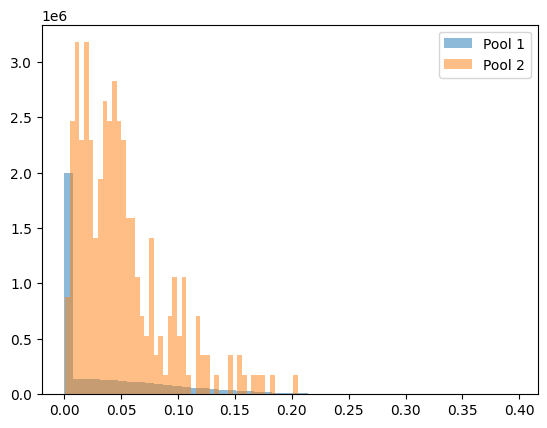

In [193]:
# Implement normalization if embeddings are not aligned. Ensures both Pool 1 and Pool 2 embeddings lie in the same space, making FAISS retrieval meaningful.
import matplotlib.pyplot as plt

with torch.no_grad():
    a = encoder_pool1(torch.tensor(candidate_feature_vector, dtype=torch.float32))
    a = pool1_embeddings = normalize_embeddings(a).numpy()  
plt.hist(a.flatten(), bins=50, alpha=0.5, label="Pool 1")
plt.hist(pool2_embeddings.flatten(), bins=50, alpha=0.5, label="Pool 2")
plt.legend()
plt.show()


In [ ]:
faiss.write_index(index, 'product_recommender_index1.faiss')

In [ ]:
combined_item_metadata.head()

,parent_asin,main_category,title,average_rating,rating_number,features,description,price,images,videos,...,author,no_of_reviews,review_age_mths,context,cleaned_context,rating_trend_slope,time_weighted_sentiment,review_sbert_embedding,product_sbert_embedding,dataset_category
0,B000CEAO3C,Movies & TV,Unlimited Energy,1.000000,0.000000,NaN,Energize Your Life for Unlimited Success! Ener...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],...,NaN,0.00000,0.255435,Unlimited Energy Energize Your Life for Unlim...,unlimited energy energize your life for unlimi...,0.686648,0.862502,[-4.03414369e-02 5.20571284e-02 -2.60858778e-...,[-2.83972137e-02 3.26147936e-02 1.58172157e-...,Movies_and_TV
1,B004OGYLGU,Movies & TV,Player of the Year,1.000000,0.000000,NaN,NaN,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],...,NaN,0.00000,0.170290,Player of the Year Movies and TV Movies & TV,player of the year movies and tv movies tv,0.686648,0.927772,[-3.34046707e-02 -3.29056452e-03 -2.24059261e-...,[-2.16525327e-02 -3.61326523e-02 1.01101287e-...,Movies_and_TV
2,B001QCKCH2,Movies & TV,Breath of Death : The Blowgun Video,1.000000,0.000008,NaN,"The blowgun is the ultimate weapon of stealth,...",NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],...,NaN,0.00000,0.324730,Breath of Death : The Blowgun Video The blowg...,breath of death the blowgun video the blowgun ...,0.686648,0.680357,[ 6.08543903e-02 -1.08727627e-02 7.06706243e-...,[-7.31304362e-02 4.40187193e-02 -3.93290706e-...,Movies_and_TV
3,B008QHAHQ6,Movies & TV,"Structure School -- Structure Fishing, Finding...",1.000000,0.000000,NaN,NaN,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],...,NaN,0.00000,0.366713,"Structure School -- Structure Fishing, Finding...",structure school structure fishing finding hid...,0.686648,0.968116,[-9.70235020e-02 -1.76641811e-02 -3.88238803e-...,[-3.47727761e-02 8.96123331e-03 9.31569282e-...,Movies_and_TV
4,B006P0FICE,Movies & TV,The Three Musketeers (Special Edition) [Blu-ray],0.761905,0.008186,NaN,An action-filled re-imagination of the Alexand...,0.023202,[{'thumb': 'https://m.media-amazon.com/images/...,[],...,NaN,0.01819,0.452287,The Three Musketeers (Special Edition) [Blu-ra...,the three musketeers special edition blu ray a...,0.686662,0.557904,[-4.14709076e-02 -5.95425740e-02 1.15352413e-...,[-5.26722558e-02 2.95322179e-03 1.92135666e-...,Movies_and_TV


In [194]:
# Sample retrieval
rand_ind = [random.randint(1, candidate_feature_vector.shape[0]) for _ in range(10)]
sample_pool1 = candidate_feature_vector[rand_ind]
similar_products, distances = find_similar_products(sample_pool1, top_n=5)

display(candidate_products.loc[rand_ind][['user_name', 'category', 'ad_product_name', 'ad_product_category', 'advertising_brand', 'recommendation_score', 'product_info']])

# Print results
for i, (neighbors, dists) in enumerate(zip(similar_products, distances)):
    print(f"\n🔍 Pool 1 Product {i}:")
    for j, (idx, dist) in enumerate(zip(neighbors, dists)):
        print(f"   - Rank {j+1}: Amazon Product {idx} {combined_item_metadata.loc[idx, 'dataset_category']} {combined_item_metadata.loc[idx, 'parent_asin']} {combined_item_metadata.loc[idx, 'title']} (Distance: {dist:.4f})")

,user_name,category,ad_product_name,ad_product_category,advertising_brand,recommendation_score,product_info
7878,nawalelzoghbi,Artist,jewellery,Clothing_Shoes_and_Jewelry,"kishandasjewellery] \n[ad,clothing_shoes_and_...",0.041542,clothing_shoes_and_jewelry jewellery kishandas...
2514,james,Arts & entertainment,concert tickets,Others,na,0.220390,others concert tickets na
10288,jacksepticeye,Video creator,cosmetics,All_Beauty,morphebrushes,0.086774,all_beauty cosmetics morphebrushes
7260,sandyoficial,Artist,tv_series,Movies_and_TV,inevitable,0.022730,movies_and_tv tv_series inevitable
5063,cantordaniel,Song,jewelry,Clothing_Shoes_and_Jewelry,tous,0.014252,clothing_shoes_and_jewelry jewelry tous
808,yeng,Musician/band,supplements,Health_and_Personal_Care,mantra,0.032517,health_and_personal_care supplements mantra
9442,anirudhofficial,Digital creator,restaurant,Others,costiera nostra,0.016195,others restaurant costiera nostra
490,souljaboy,Musician/band,single,CDs_and_Vinyl,"na] \n[ad,cds_and_vinyl,mixtape,na",0.014894,"cds_and_vinyl single na] \n[ad,cds_and_vinyl,..."
13430,mrfunny1_,Comedian,activewear,Sports_and_Outdoors,gymshark,0.029646,sports_and_outdoors activewear gymshark
9060,mreazi,Musician,concert_tickets,Others,patriotmobileusa,0.007821,others concert_tickets patriotmobileusa



🔍 Pool 1 Product 0:
   - Rank 1: Amazon Product 4 Movies_and_TV B006P0FICE The Three Musketeers (Special Edition) [Blu-ray] (Distance: 0.7187)
   - Rank 2: Amazon Product 3 Movies_and_TV B008QHAHQ6 Structure School -- Structure Fishing, Finding Hidden Hot Spots with Woo Daves, Bass Pro Shops Production (Distance: 0.7187)
   - Rank 3: Amazon Product 2 Movies_and_TV B001QCKCH2 Breath of Death : The Blowgun Video (Distance: 0.7187)
   - Rank 4: Amazon Product 1 Movies_and_TV B004OGYLGU Player of the Year (Distance: 0.7187)
   - Rank 5: Amazon Product 0 Movies_and_TV B000CEAO3C Unlimited Energy (Distance: 0.7187)

🔍 Pool 1 Product 1:
   - Rank 1: Amazon Product 4 Movies_and_TV B006P0FICE The Three Musketeers (Special Edition) [Blu-ray] (Distance: 0.7517)
   - Rank 2: Amazon Product 3 Movies_and_TV B008QHAHQ6 Structure School -- Structure Fishing, Finding Hidden Hot Spots with Woo Daves, Bass Pro Shops Production (Distance: 0.7517)
   - Rank 3: Amazon Product 2 Movies_and_TV B001QCKCH2 Bre

In [61]:
!apt-get install libopenblas-dev -y
!pip install faiss-cpu  # Install CPU version first
!pip install --no-cache-dir --force-reinstall faiss-gpu

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\anira\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\anira\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for faiss-gpu


In [18]:
# Transform Pool 2 into the learned latent space
pool1_latent_embeddings = encoder_pool1.predict(candidate_feature_vector)

# Transform Pool 1 into the same latent space
pool2_latent_embeddings = encoder_pool2.predict(amazon_pca_features)

# Save embeddings for FAISS retrieval
np.save("candidate_faiss_embeddings.npy", pool1_latent_embeddings)
np.save("amazon_faiss_embeddings.npy", pool2_latent_embeddings)

504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
2911/2911 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


< 0.01 :	Very Good – The autoencoder effectively reconstructs embeddings with minimal loss.

0.01 - 0.05 :	Acceptable – Some information is lost, but retrieval may still work well.

\> 0.05 :	Too High – The latent space is not capturing enough information, and retrieval performance will degrade.

If Pool 1 embeddings overlap well with Pool 2 embeddings, FAISS retrieval will work properly.

 If Pool 1 clusters separately, the encoders may need better training.

Seems to be recommending roughly the same products.

Makes sense since we do not have enough product context. Find new ways to add more information about the product.

1. Use ChatGPT to generate short text about available data
2. Use post captions

In [ ]:
from collections import defaultdict
import numpy as np

# Dictionary to store final influencer fit scores for Pool 2 products
pool2_influencer_fit = defaultdict(float)
pool2_total_weight = defaultdict(float)
collaborative_filtering_scores = defaultdict(float)

# Loop through FAISS retrievals (Pool 1 → Pool 2 mappings)
for i, pool1_product in candidate_products.iterrows():
    for j, pool2_product in enumerate(I[i]):  # I contains FAISS-retrieved Pool 2 indices
        cbf_score = D[i, j]  # FAISS similarity score
        influencer_fit = pool1_product['influencer_product_fit']  # Pool 1 influencer fit
        recommendation_score = pool1_product['recommendation_score']  # Pool 1 recommendation score

        # Weighted sum
        pool2_influencer_fit[pool2_product] += influencer_fit * cbf_score
        collaborative_filtering_scores[pool2_product] += recommendation_score * cbf_score
        pool2_total_weight[pool2_product] += cbf_score

# Compute final influencer fit for Pool 2
for product in pool2_influencer_fit:
    if pool2_total_weight[product] > 0:
        pool2_influencer_fit[product] /= pool2_total_weight[product]  # Normalize
        collaborative_filtering_scores[product] /= pool2_total_weight[product]  # Normalize


In [ ]:
from collections import Counter
import numpy as np

# Count frequency of each recommended product
product_counts = Counter(I.flatten())  # I contains FAISS retrieved indices

# Normalize frequency scores
total_retrieved = len(I.flatten())
frequency_scores = {k: v / total_retrieved for k, v in product_counts.items()}

In [ ]:
# Define weights
w1, w2, w3, w4 = 0.4, 0.3, 0.2, 0.1  # Tune these values

# Compute final scores
final_scores = {}
for product_id in pool2_influencer_fit:
    frequency_score = frequency_scores.get(product_id, 0)
    influencer_fit = pool2_influencer_fit[product_id]  # Now computed for Pool 2
    cbf_score = np.mean(D[:, np.where(I == product_id)[1]])  # Average FAISS similarity
    cf_score = collaborative_filtering_scores.get(product_id, 0)  # ALS prediction

    # Compute weighted score
    final_scores[product_id] = (
        w1 * frequency_score + w2 * influencer_fit + w3 * cbf_score + w4 * cf_score
    )

# Rank products by final score
ranked_products = sorted(final_scores.keys(), key=lambda x: -final_scores[x])


In [ ]:
ranked_products

[8905,
 7433,
 85106,
 94282,
 34211,
 42151,
 920,
 81684,
 6357,
 10419,
 4015,
 27811,
 402,
 7377]

In [ ]:
candidate_products.iloc[query_index]

,81
user_id,1783442
user_name,joeygraceffa
follower_count,6643342.0
category,Video creator
avg_likes_per_post(k),37.3
product,cosmetics
ad_product_category,All_Beauty
advertising_brand,Jeffree_Star
predicted_likes(k),33.5
engagement_change,-0.101


In [ ]:
item_metadata.iloc[ranked_products]

,parent_asin,title,average_rating,rating_number,main_category,features,description,price,store,no_of_reviews,rating_trend_slope,context,cleaned_context,time_weighted_sentiment,review_sbert_embedding
8907,B07KWTMH8M,Himalayan Pink Salt Body Scrub 12oz - Rose Sce...,0.850,0.000232,All Beauty,[],[],NaN,AG TRADEMARK LLC,0.002217,0.780335,Himalayan Pink Salt Body Scrub 12oz - Rose Sce...,himalayan pink salt body scrub 12oz rose scent...,0.823949,[-7.16810524e-02 -5.71631119e-02 1.28711000e-...
7435,B08DCHXQWB,Maybelline Master Fixer Makeup Remover Pen,0.875,0.030028,All Beauty,[],['Master Fixer Makeup Remover Pen instantly re...,0.003162,MAYBELLINE,0.046563,0.780320,Maybelline Master Fixer Makeup Remover Pen [] ...,maybelline master fixer makeup remover pen mas...,0.747897,[-1.03510983e-01 -2.92523764e-02 8.41827616e-...
85112,B08D6JPSW7,Orthodontic Ligature Ties Transparent White Or...,0.750,0.000662,All Beauty,[],[],NaN,Jrehoor,0.000554,0.780320,Orthodontic Ligature Ties Transparent White Or...,orthodontic ligature ties transparent white or...,0.527922,[-5.56245781e-02 -4.50811535e-02 3.15846838e-...
94288,B004G6NL5U,Belgian Hops Beer Soap - Made with Chimay Gran...,0.250,0.000000,All Beauty,[],[],NaN,Unknown,0.000000,0.780320,Belgian Hops Beer Soap - Made with Chimay Gran...,belgian hops beer soap made with chimay grande...,0.600292,[-1.82090402e-02 -8.02748427e-02 -2.57273465e-...
34216,B0771G95LV,10A Brazilian Closure Body Wave 100% Unprocess...,0.700,0.000199,All Beauty,[],[],NaN,Unknown,0.000554,0.780279,10A Brazilian Closure Body Wave 100% Unprocess...,10a brazilian closure body wave one hundred un...,0.553329,[-6.48600534e-02 4.95429970e-02 1.17882984e-...
42156,B07YM3HDRT,Cornucopia 15ml Black-Coated Glass Dropper Bot...,0.850,0.001887,All Beauty,[],[],NaN,Cornucopia Brands,0.002217,0.780341,Cornucopia 15ml Black-Coated Glass Dropper Bot...,cornucopia 15ml black coated glass dropper bot...,0.775339,[-9.19645056e-02 -5.06594479e-02 4.42355536e-...
921,B08N57C9ZR,Hydrating Eye Cream - Rapid Wrinkle Repair Ant...,0.750,0.002020,All Beauty,[],[],NaN,iBaste,0.000554,0.780314,Hydrating Eye Cream - Rapid Wrinkle Repair Ant...,hydrating eye cream rapid wrinkle repair anti ...,0.991594,[-6.08933456e-02 -2.93877460e-02 3.73127237e-...
81690,B07BMV2MLY,"Shaving Bowl, Sky-shop Stainless Steel Shaving...",0.800,0.000232,All Beauty,[],[],NaN,Pei Mei,0.000554,0.780320,"Shaving Bowl, Sky-shop Stainless Steel Shaving...",shaving bowl sky shop stainless steel shaving ...,0.885794,[-4.33383137e-02 -3.38373594e-02 3.84366959e-...
6358,B00PR47CT6,Titan Classic Dreadlock Stocking Cap #22135 [B...,0.725,0.000397,All Beauty,"['Expandable', 'Breathable', 'Stretchable', 'C...",[],0.002346,Titan Classic,0.002217,0.780323,Titan Classic Dreadlock Stocking Cap #22135 [B...,titan classic dreadlock stocking cap twenty-tw...,0.828831,[-2.80256122e-02 4.64744642e-02 3.18309106e-...
10421,B07WG128B9,Bomb Twist Crochet Hair Mini Passion Twist Hai...,0.800,0.000993,All Beauty,[],[],NaN,procener,0.000554,0.780327,Bomb Twist Crochet Hair Mini Passion Twist Hai...,bomb twist crochet hair mini passion twist hai...,0.981147,[-6.39401153e-02 -5.32772690e-02 6.77767098e-...


In [ ]:
from scipy.spatial.distance import cosine

# Compute similarity between first Pool 1 product and its retrieved matches
query_embedding = pool1_latent_embeddings[0]
retrieved_embeddings = pool2_latent_embeddings[I[0]]

# Compute cosine similarity
cos_similarities = [1 - cosine(query_embedding, emb) for emb in retrieved_embeddings]
print("Cosine Similarities of Retrieved Matches:", cos_similarities)


Cosine Similarities of Retrieved Matches: [0.403129594344919, 0.3754217420519428, 0.4153658099565056, 0.42862246995943387, 0.4267502628049946, 0.3956840791448262, 0.39610161783421494, 0.3899073270701441, 0.4414396788027368, 0.4419122289610615]


Use PCA variance analysis on Pool 2 to find how many dimensions capture 95-99% of the variance in the Amazon dataset. Reduce noise by removing redundant/unimportant dimensions, speed up training.

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Perform PCA on Pool 2 embeddings
pca = PCA()
pca.fit(amazon_feature_vector)

# Compute cumulative variance explained
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find minimum number of dimensions that explain 99% variance
encoding_dim = np.argmax(explained_variance >= 0.99) + 1  # +1 because index starts at 0
print("Optimal Encoding Dimension:", encoding_dim)
